In [ ]:
pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from arch import arch_model
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
df = pd.read_csv('/content/my_dataframe.csv')

In [ ]:
#os.makedirs('plots')

In [ ]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 300
val_size = 400

# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [ ]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 0 	to: 2399 	2400 days
VALIDATION 	From: 2400 	to: 2799 	400 days
TEST 		From: 2800 	to: 3099 	300 days


In [ ]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [ ]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for baseline, random walk, and NN models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [ ]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [ ]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

In [ ]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [ ]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [ ]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

In [ ]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [ ]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION

def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [ ]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [ ]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df

In [ ]:
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
def viz_model(y_true, y_pred, model_name):
    sns.set_context("paper", font_scale=1.7)
    plt.rcParams["axes.grid"] = False

    with sns.axes_style("whitegrid"):
        plt.figure(figsize=(18,7))
        plt.plot(x_val_scaled, color='gray',  ls=':',
                label=f"Scaled Current Daily Volatility")
        
        plt.plot(y_true, color='blue', lw=2, 
                label=f"Target Volatility")
        plt.plot(y_pred, color='orange', lw=2.5,
                label=f'Forecasted Volatility')
        
        # plt.plot(lr_val, color='gray', alpha=0.4,
        #         label='Daily Log Returns')

        plt.title(f'{model_name} \non Validation Data')
        plt.legend(loc='best', frameon=True)

## 2. Baseline Models

### 2.1. Mean Baseline

One of the essential characteristics of Volatility is it's **mean-revert** over the long term. Therfore my first baseline model his would be a very simple one that only outputs the average current realized volatility of the whole training set as predictions everything.

یکی از ویژگی‌های اساسی فراریت، بازگشت میانگین آن در دراز مدت است. بنابراین اولین مدل پایه من او یک مدل بسیار ساده خواهد بود که تنها نوسانات متوسط ​​جریان متوجه کل مجموعه آموزشی را به عنوان پیش‌بینی همه چیز، خروجی می‌دهد.

In [ ]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()
mean_train_vol

0.2963906494519395

In [ ]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

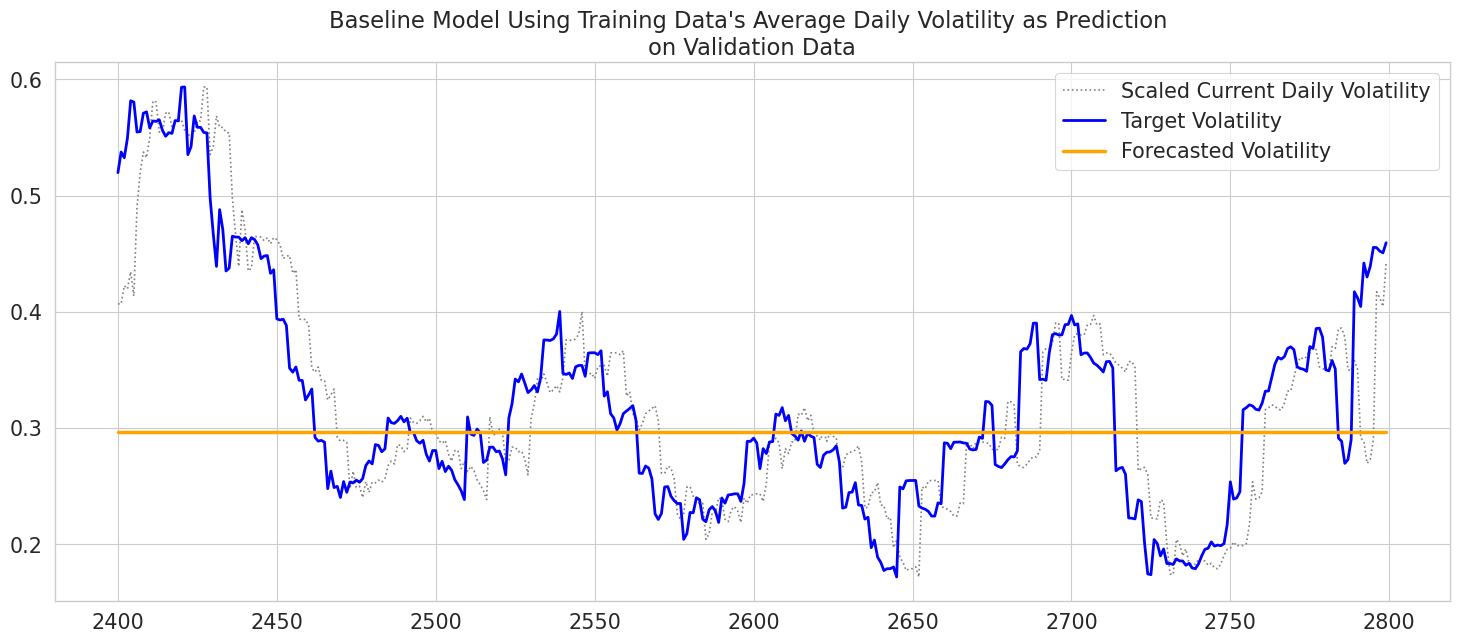

In [ ]:
viz_model(y_val_scaled, baseline_preds, 
          f"Baseline Model Using Training Data's Average Daily Volatility as Prediction")
plt.savefig('plots/plot1_baseline.jpg' ,dpi=300, bbox_inches='tight')
plt.show();

In [ ]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.277381,0.099119


### 2.2. Random Walk Naive Forecasting

A commonly known fact about volatility is that it tends to be **autocorrelated**, and **clusters** in the short-term. This property can be used to implement a naive model that just "predicts" future volatility by using whatever the daily volatility was at the immediate previous time step.

In this case, I'll use the average daily volatility of the most recent `INTERVAL_WINDOW` as predictions for the next 7 days, which is essentially using `vol_current` at time step `t` and prediction for `vol_future` at time step `t`.

یک واقعیت رایج در مورد نوسانات این است که تمایل به همبستگی خودکار دارد و در کوتاه مدت خوشه می شود. این ویژگی را می توان برای پیاده سازی یک مدل ساده و بی تکلف استفاده کرد که فقط نوسانات آینده را با استفاده از هر آنچه که نوسانات روزانه در مرحله زمانی قبلی بود، "پیش بینی" می کند.

در این مورد، من از میانگین نوسان روزانه جدیدترین INTERVAL_WINDOW به عنوان پیش‌بینی برای 7 روز آینده استفاده می‌کنم، که اساساً از vol_current در مرحله زمانی t و پیش‌بینی برای vol_future در مرحله زمانی t استفاده می‌کند.


In [ ]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

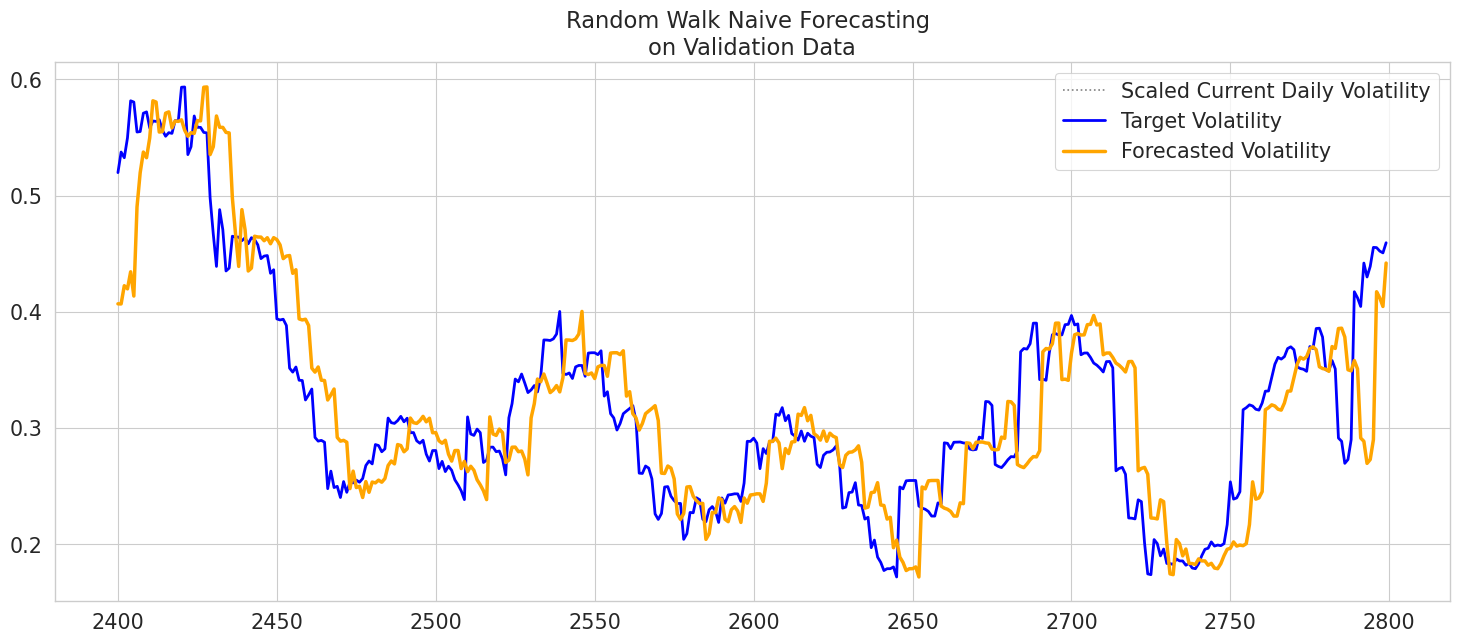

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, random_walk_preds, 'Random Walk Naive Forecasting')
plt.savefig('plots/plot2_naive.jpg', dpi=300, bbox_inches='tight')
           
plt.show();

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, random_walk_preds, 
         'Random Walk Naive Forecasting')

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.277381,0.099119
1,Random Walk Naive Forecasting,0.159563,0.049610


So the both error mertrics have gone down by a decent amount. Naive forecasting in time series is sometimes surprisingly difficult to outperform.

chat GPT :

متن کاهش دو معیار خطا را مورد بحث قرار می دهد، به این معنی که دقت یک مدل پیش بینی بهبود یافته است. نوع خاصی از پیش بینی که به آن اشاره می شود، پیش بینی ساده در سری های زمانی است. پیش بینی ساده و بی تکلف یک روش پیش بینی ساده است که در آن مقادیر آینده یک متغیر با مقادیر قبلی یکسان فرض می شود. عملکرد بهتر از این روش گاهی دشوار است، به این معنی که روش‌های پیش‌بینی پیچیده‌تر ممکن است لزوما دقیق‌تر نباشند.

## 3. GARCH Models

(Reference: http://users.metu.edu.tr/ozancan/ARCHGARCHTutorial.html)

GARCH stands for **Generalized Autoregressive Conditional Heteroskedasticity**, which is an extension of the ARCH model (Autoregressive Conditional Heteroskedasticity). 

GARCH includes lag variance terms with lag residual errors from a mean process, and is the traditional econometric approach to volatility prediction of financial time series.

Mathematically, GARCH can be represented as follows:

\begin{align*}
\sigma_{t}^2 = \omega + \sum_{i}^{q}\alpha_{i}\epsilon_{t-i}^2 + \sum_{1}^{p}\beta_{i}\sigma_{t-i}^2
\end{align*}

in which $\sigma_{t}^2$ is variance at time step `t` and $\epsilon_{t-i}^2$ is the model residuals at time step `t-1`

GARCH(1,1) only contains first-order lagged terms and the mathematic equation for it is: 

\begin{align*}
\sigma^2_t = \omega + \alpha\epsilon^{2}_{(t-1)} + \beta\sigma^{2}_{(t-1)}
\end{align*}

where $\alpha$, $\beta$ and $\omega$ sum up to 1, and $\omega$ is the long term variance.


(Reference: **Positional Option Trading** - Euan Sinclair)

GARCH is generally regarded as an insightful improvement on naively assuming future volatility will be like the past, but also considered widely overrated as predictor by some experts in the field of volatility. GARCH models capture the essential characteristics of volatility: volatility tomorrow will be close to what it is today (**clustering**), and volatility in the long term will probably **mean revert** (meaning it'd be close to whatever the historical long-term average has been).

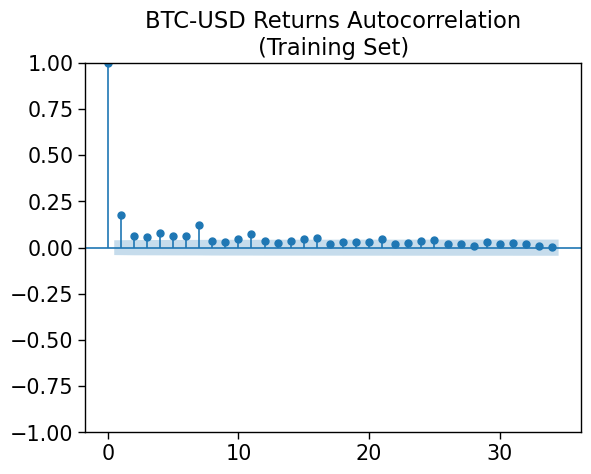

In [ ]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
tckr = 'BTC-USD'
plot_acf(r_train**2, 
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');
plt.savefig('plots/plot3_Returns Autocorrelation\n(Training Set)')

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


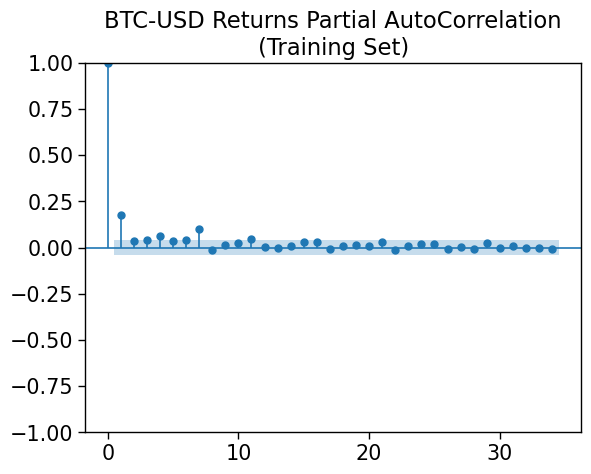

In [ ]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2, 
          title=f'{tckr.upper()} Returns Partial AutoCorrelation\n(Training Set)');
plt.savefig('plots/plot4_Returns Partial AutoCorrelation\n(Training Set)')

The autocorrelation plots seem to indicate that there's only significant correlation up to the 7th lags, and the ones following don't seem to be too significant.

GARCH models are trained on percent returns. (One of the reasons I decided to normalize the volatilities across the board is because I am still not 100% sure which timescale GARCH conditional volatility is calculated in (likely daily), and still haven't figured out why the outputs here seem to be on a totally different scale compared to the volatilities previously calculated. Once I scale them, they match up much more nicely).

به نظر می رسد نمودارهای خودهمبستگی نشان می دهد که فقط تا 7th وقفه همبستگی معنی داری وجود دارد و موارد زیر چندان معنی دار به نظر نمی رسند.

مدل‌های GARCH با درصد بازدهی آموزش دیده‌اند. (یکی از دلایلی که من تصمیم گرفتم نوسانات را در سراسر صفحه عادی کنم این است که هنوز 100% مطمئن نیستم که نوسانات شرطی GARCH در کدام مقیاس زمانی محاسبه می شود (احتمالاً روزانه) و هنوز متوجه نشده ام که چرا خروجی ها در اینجا به نظر می رسد در مقیاسی کاملاً متفاوت در مقایسه با نوساناتی که قبلاً محاسبه شده بود. هنگامی که آنها را مقیاس‌بندی می‌کنم، بسیار زیباتر با هم مطابقت دارند).

In [ ]:
# SET SEED FOR REPRODUCIBILITY
seed = 666
np.random.seed(seed)

gm_1 = arch_model(r_train, p=7, q=7)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6418.37
Distribution:                  Normal   AIC:                           12868.7
Method:            Maximum Likelihood   BIC:                           12961.3
                                        No. Observations:                 2400
Date:                Thu, Apr 20 2023   Df Residuals:                     2399
Time:                        23:18:59   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2276  7.067e-02      3.221  1.277e-03 [8.913e-



ضرایب تخمین زده شده برای ترم های GARCH و ARCH که به ترتیب نشان دهنده قدرت خوشه بندی نوسانات و تداوم شوک ها هستند.
مقدار log-likelihood، که معیاری است برای اینکه مدل چقدر با داده ها مطابقت دارد.
معیار اطلاعات آکایک (AIC) و معیار اطلاعات بیزی (BIC)، که معیارهای برازش مدل هستند که تعداد پارامترهای مدل را در نظر می گیرند.
باقیمانده های استاندارد شده، که باقی مانده ها بر انحراف استاندارد شرطی تخمین زده شده تقسیم می شوند. از اینها می توان برای بررسی الگوهای باقی مانده در داده هایی که مدل ثبت نکرده است استفاده کرد.
برای تجزیه و تحلیل خروجی ها، باید با نگاه کردن به تخمین ضرایب برای عبارت های GARCH و ARCH شروع کنید. ضرایب مثبت نشان دهنده خوشه بندی نوسانات است، در حالی که ضرایب منفی نشان دهنده بازگشت میانگین است. مقدار لاگ احتمال باید حداکثر شود و مقادیر پایین تر AIC و BIC نشان دهنده تناسب بهتر مدل است. در نهایت، باید الگوهای موجود در باقیمانده‌های استاندارد شده را بررسی کنید، که ممکن است نشان‌دهنده این باشد که مدل تمام ویژگی‌های مربوط به داده‌ها را در بر نمی‌گیرد.
All coefficients look statistically significant now.

After being fitted to the training data (percent returns), the GARCH model forecast contains an estimated conditional volatility attribute for the training portion of the time series. I am going to fit - transform the scaler to the training data's conditional volatility arrays, and then plot it out to compare it with the realized volatility calculated above (also scaled) `x_train_scaled`.

In [ ]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility 
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [ ]:
INTERVAL_WINDOW = 30
n_future = 7


In [ ]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY 
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

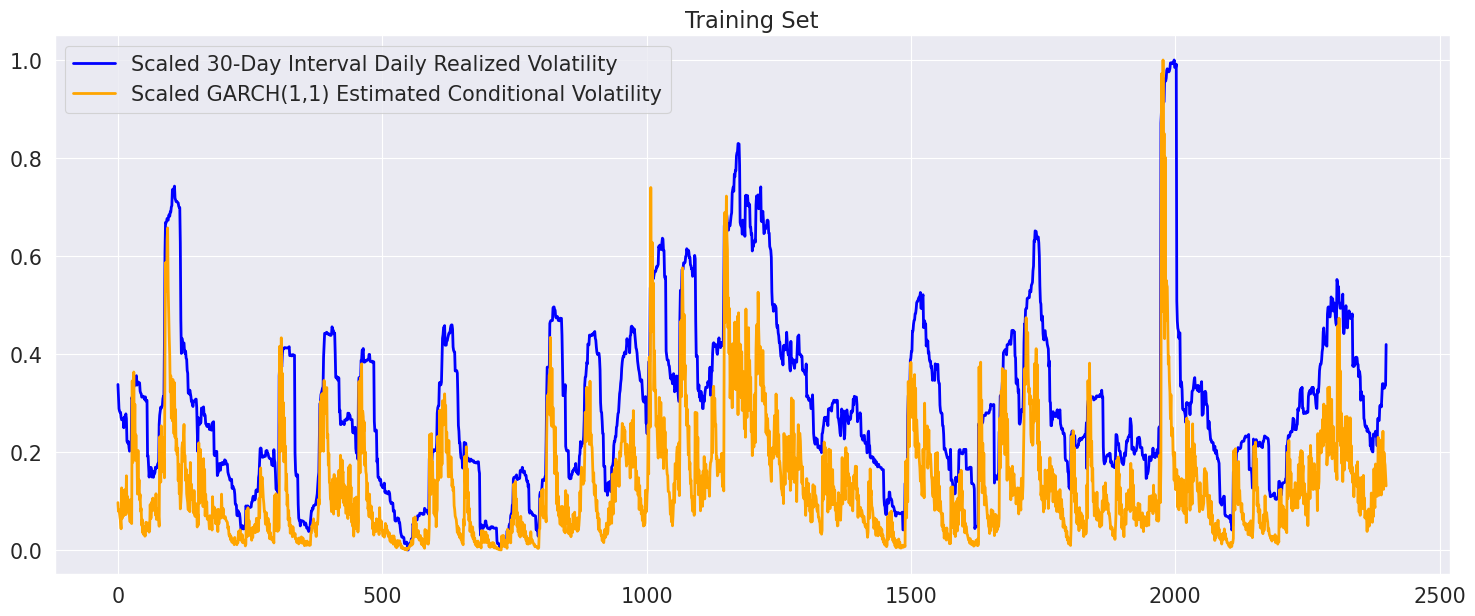

<Figure size 640x480 with 0 Axes>

In [ ]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')
plt.savefig('plots/plot5_GARCH_estimated_trainingset')

In [ ]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]
    
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

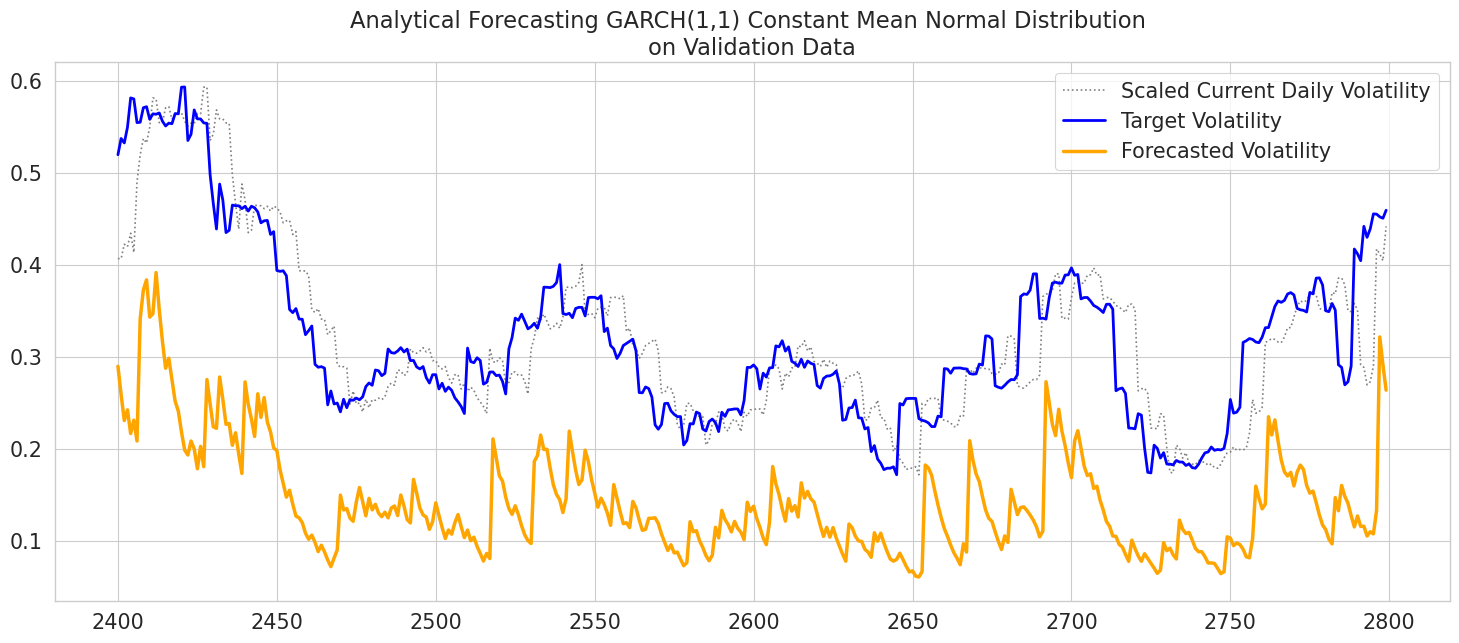

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gm_1_preds_scaled, 
          'Analytical Forecasting GARCH(1,1) Constant Mean Normal Distribution')
plt.savefig('plots/plot6_GARCH(1,1)_forecasting_validationData')

So 7-day horizon forecasting into the future is still lagging behind compared to target values. Similar to the training volatilities comparison above, GARCH's forecasted volatility appears to be lower side (after normalization).

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 
         'GARCH(1,1), Constant Mean, Normal Dist')

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.277381,0.099119
1,Random Walk Naive Forecasting,0.159563,0.049610
2,"GARCH(1,1), Constant Mean, Normal Dist",0.563884,0.186670


In [ ]:
perf_df

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.277381,0.099119
1,Random Walk Naive Forecasting,0.159563,0.049610
2,"GARCH(1,1), Constant Mean, Normal Dist",0.563884,0.186670


Next, I would inspect the estimated residuals from this first GARCH model.

<ipython-input-58-9dd6b6363302>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)


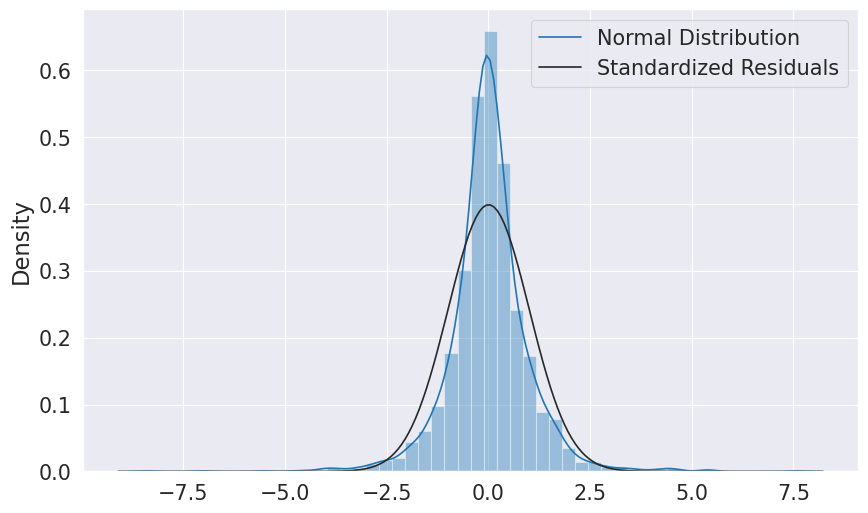

<Figure size 640x480 with 0 Axes>

In [ ]:
  # INSPECTING THE RESIDUALS
  #توزیع نرمال در مقابل باقیمانده های استاندارد شده
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();
plt.savefig('plots/plot7_Normal Distribution VS Standardized Residuals')

(Reference: https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/)

By default, basic GARCH is based on some assumptions that the residuals and the mean return are both normally distributed. However, more often than not, financial time series data does not follow a normal distribution, and it's more likely to observe extreme positive and negative values that are far away from the mean. 

Fortunately, there're certain parameters that can be specified in the `arch_model` library to make it more representative of real financial data:
- `'dist'` can be set to `t` for Student's T or `skewt` for skewed Student's T distribution (Student's T distribution is also symmetric and bell-shaped like normal distribution; however it has higher peak and fatter tails allowing more values lying further away from the mean).

Looking at the plot above of the standardized residuals, I think I can try skewed Student's T for the next fit.



### 3.2. GARCH Model with Asymmetric Shocks Responses

The basic GARCH model assumes positive and negative news have similar impact on volatility. However, in reality the market tends to "*take the stairs up and the elevator down*". In other words, the impact is usually asymmetric, and negative impacts tends to affect the volatility more than positive ones.

There's another member in the GARCH family that accounts for assymmetry of shocks reponses called **GJR-GARCH** (short for **Glosten-Jagannathan-Runkle GARCH**).

Additional inputs can be used to construct other models. In this case, by setting `o` to 1, which means the model would include one lag of an asymmetric shock which transforms a GARCH model into a GJR-GARCH model with variance dynamics.

مدل GARCH با پاسخ های شوک نامتقارن
مدل پایه GARCH فرض می کند که اخبار مثبت و منفی تأثیر مشابهی بر نوسان دارند. با این حال، در واقعیت، بازار تمایل دارد "پله ها را بالا و آسانسور را پایین بیاورد". به عبارت دیگر، تأثیر معمولاً نامتقارن است و تأثیرات منفی بیشتر از تأثیرات مثبت بر نوسانات تأثیر می گذارد.

عضو دیگری در خانواده GARCH وجود دارد که عدم تقارن پاسخ شوک ها را به نام GJR-GARCH (مخفف Glosten-Jagannathan-Runkle GARCH) به حساب می آورد.

می توان از ورودی های اضافی برای ساخت مدل های دیگر استفاده کرد. در این مورد، با تنظیم o بر روی 1، به این معنی که مدل شامل یک تاخیر یک شوک نامتقارن است که یک مدل GARCH را به یک مدل GJR-GARCH با دینامیک واریانس تبدیل می‌کند.

In [ ]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1, 
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -6073.89
Distribution:      Standardized Skew Student's t   AIC:                           12161.8
Method:                       Maximum Likelihood   BIC:                           12202.3
                                                   No. Observations:                 2400
Date:                           Thu, Apr 20 2023   Df Residuals:                     2399
Time:                                   23:19:26   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

Log-likelihood has increased quite a bit. Let's see how the conditional volatility looks.

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_2)

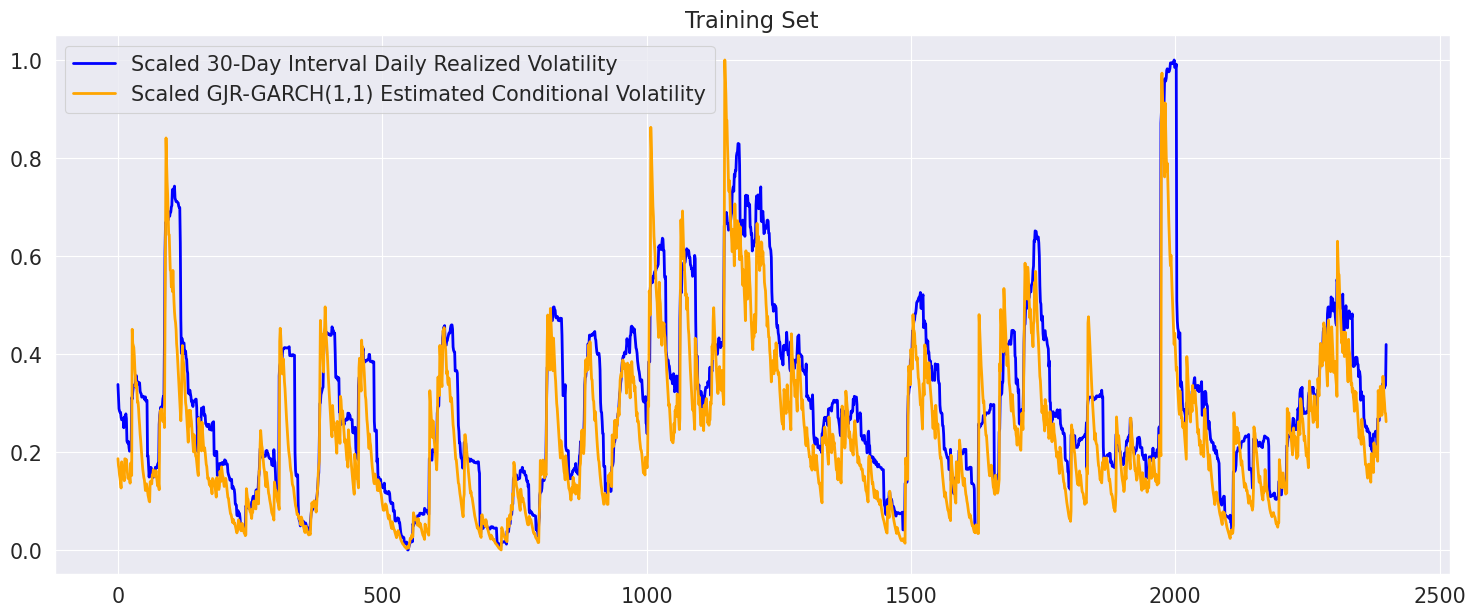

<Figure size 640x480 with 0 Axes>

In [ ]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')
plt.savefig('plots/plot8_GJR-GARCH(1,1)estimate_trainingData')

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

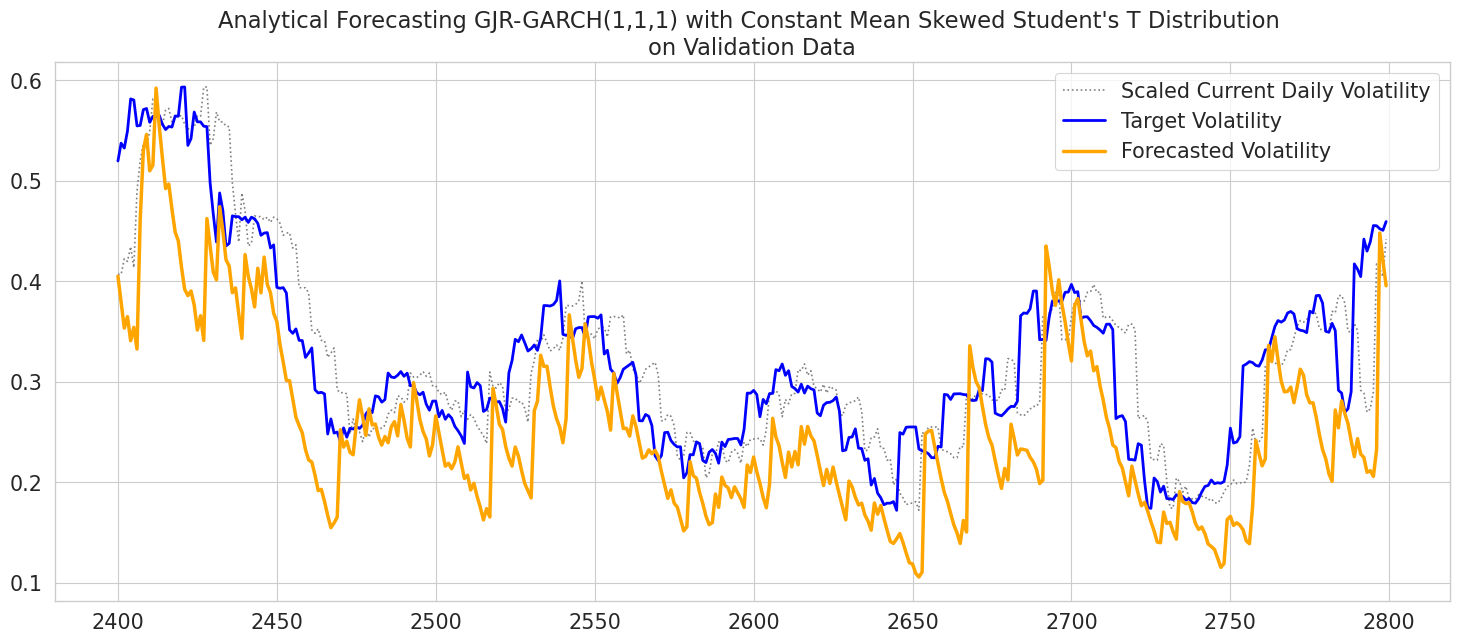

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, gjr_1_preds_scaled, 
          "Analytical Forecasting GJR-GARCH(1,1,1) with Constant Mean Skewed Student's T Distribution")
plt.savefig('plots/plot9_GJR-GARCH(1,1,1)forecasting_validationData')

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_1_preds_scaled, 
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.277381,0.099119
1,Random Walk Naive Forecasting,0.159563,0.049610
2,"GARCH(1,1), Constant Mean, Normal Dist",0.563884,0.186670
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Sk...",0.249559,0.084548


Compared to GARCH(1,1) with Normal Distribution setting, GJR-GARCH with Skewed Student's T forecasts have moved up quite a bit and shortened the gap between target values and model's predictions. This is also reflected in an improvement in both Validation RMSPE and RMSE.

Unfortunately I still haven't been able to get close to Naive Forecasting.

در مقایسه با GARCH(1،1) با تنظیم توزیع عادی، GJR-GARCH با پیش‌بینی T Skewed Student کمی بالا رفته و فاصله بین مقادیر هدف و پیش‌بینی‌های مدل را کوتاه کرده است. این نیز در بهبود اعتبار RMSPE و RMSE منعکس شده است.

متأسفانه هنوز نتوانسته ام به پیش بینی ساده لوح نزدیک شوم.

### 3.3. TARCH

(Reference: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html#Specifying-Common-Models)

There's another member in the GARCH family called **TARCH**, which is short for **Threshold Autoregressive Conditional Heteroskedasticity** (and also known as **ZARCH**). TARCH models the volatility using absolute values (instead of squares). This model is specified using `power=1.0` since the default power, `2.0`, corresponds to variance processes that evolve in squares. In addition, asymmetric impact is also incorporated into the GARCH framework by using a dummy variable

The volatility process in a TARCH(1,1) model is given by:

\begin{align*}
\sigma_{t} = \omega + \alpha|\epsilon_{t-1}| + \gamma|\epsilon_{t-1}|I_{[\epsilon_{t-1}<0]} + \beta\sigma_{t-1}
\end{align*}

In [ ]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_gm = arch_model(r_train, p=1, o=1, q=1, power=1.0,
                  dist='skewt')
result_3 = t_gm.fit(disp='off')
print(result_3.summary())

                        Constant Mean - TARCH/ZARCH Model Results                        
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           TARCH/ZARCH   Log-Likelihood:               -6072.38
Distribution:      Standardized Skew Student's t   AIC:                           12158.8
Method:                       Maximum Likelihood   BIC:                           12199.2
                                                   No. Observations:                 2400
Date:                           Thu, Apr 20 2023   Df Residuals:                     2399
Time:                                   23:20:33   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

Log-likelihood and AIC/BIC are quite similar to the GJR-GARCH model. Next I'll inspect the estimated conditional volatility compared to the scaled `vol_current`.

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch, scaled_tarch_cond_vol = scale_tf_cond_vol(result_3)

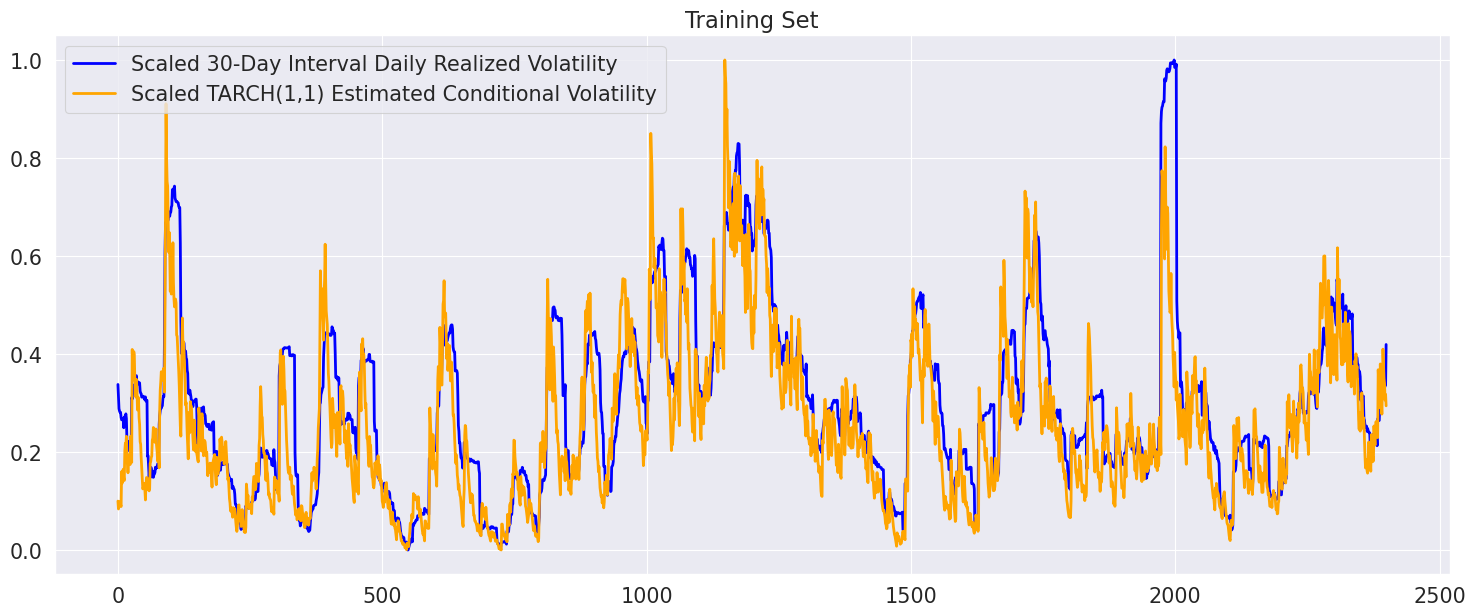

<Figure size 640x480 with 0 Axes>

In [ ]:
viz_cond_vol(scaled_tarch_cond_vol, 'TARCH(1,1)')
plt.savefig('plots/plot10_TARCH(1,1)estimate_trainingData')

#### 3.3.1. Bootstrap-based Forecasting for TARCH(1,1)

(Reference: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html#TARCH)

TARCH models do not have closed-form (analytical) forecasts for horizons larger than 1, and so simulation or bootstrapping is required.

Bootstrap-based forecasts are nearly identical to simulation-based forecasts except that the values used to simulate the process are computed from historical data rather than using the assumed distribution of the residuals. Forecasts produced using this method also return an `ARCHModelForecastSimulation` containing information about the simulated paths.

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/loc

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_bs_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_bs_preds)

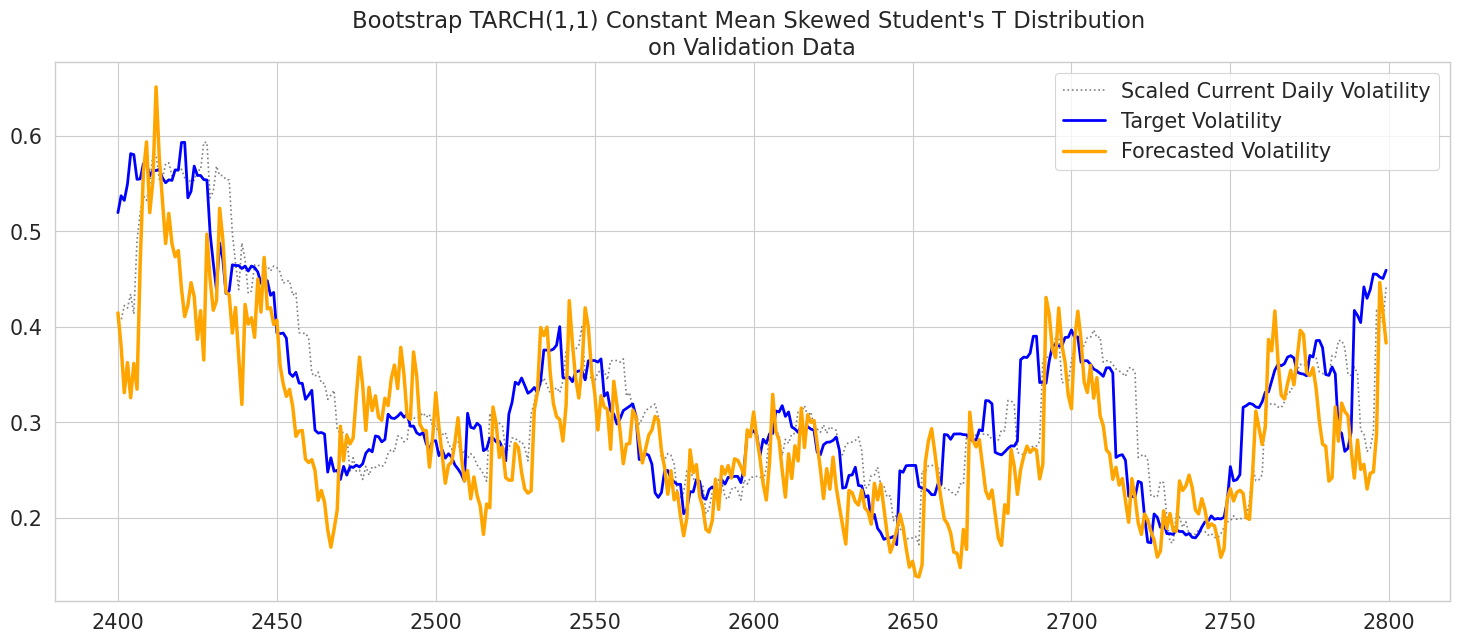

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_bs_preds_scaled, 
          "Bootstrap TARCH(1,1) Constant Mean Skewed Student's T Distribution")
plt.savefig('plots/plot11_TARCH(1,1)forecasting_validationData')

The forecasted volatility does seem to catch up with the target better than all other models did. This is promising...

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_bs_preds_scaled, 
         "Bootstrap TARCH(1,1), Constant Mean, Skewt Dist")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.277381,0.099119
1,Random Walk Naive Forecasting,0.159563,0.049610
2,"GARCH(1,1), Constant Mean, Normal Dist",0.563884,0.186670
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Sk...",0.249559,0.084548
4,"Bootstrap TARCH(1,1), Constant Mean, Skewt Dist",0.188235,0.066256


Bootstrap TARCH(1,1) has managed to achieve a lower Validation RMSPE than Naive Forecasting!!! Even RMSE is only a bit higher, but so far this has been the best model among all GARCH family members that I've found. 

(I'm not liking the ConvergenceWarning messages that TARCH produces during training though...)

#### 3.3.2. Simulation-based Forecasting for TARCH(1,1)



In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, o=1, q=1, power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING SIMULATION METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='simulation').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_sm_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/loc

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_sm_preds_scaled = transform_volatility_to_scaler(scaler_tarch, t_sm_preds)

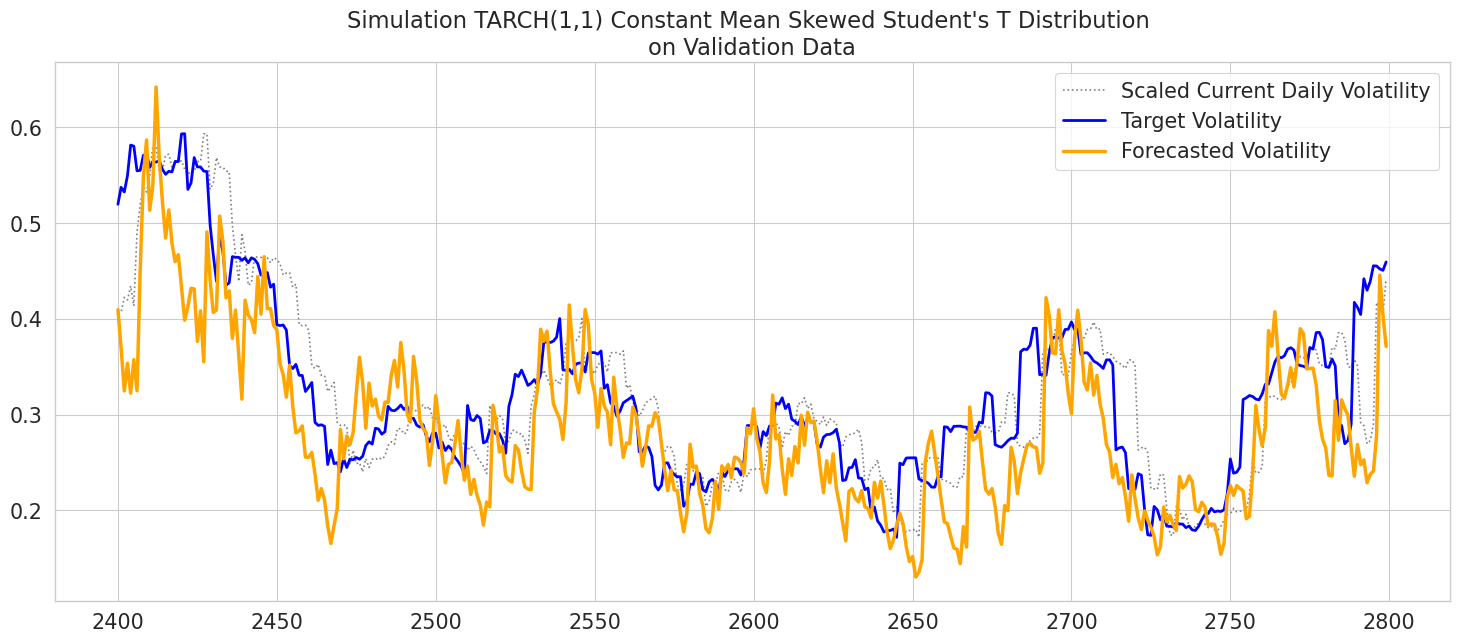

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_sm_preds_scaled, 
          "Simulation TARCH(1,1) Constant Mean Skewed Student's T Distribution")
plt.savefig('plots/plot12_simulation_TARCH(1,1)forecasting_validationData')

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_sm_preds_scaled, 
         "Simulation TARCH(1,1), Constant Mean, Skewt Dist")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.277381,0.099119
1,Random Walk Naive Forecasting,0.159563,0.049610
2,"GARCH(1,1), Constant Mean, Normal Dist",0.563884,0.186670
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Sk...",0.249559,0.084548
4,"Bootstrap TARCH(1,1), Constant Mean, Skewt Dist",0.188235,0.066256
5,"Simulation TARCH(1,1), Constant Mean, Skewt Dist",0.194583,0.069195


Among the 2 forecasting methods, bootstrap seems to perform better on TARCH(1,1). It's probably because bootstrap uses historical data in to compute rather than using the assumed distribution of the residuals.

در بین 2 روش پیش بینی، به نظر می رسد که بوت استرپ در TARCH (1،1) عملکرد بهتری دارد. احتمالاً به این دلیل است که بوت استرپ به جای استفاده از توزیع فرضی باقیمانده ها، از داده های تاریخی برای محاسبه استفاده می کند

#### 3.3.3. Hyperparameter Tuning for TARCH

Next, I'll create a range of values for p, q and o from 0 to 3 (inclusive), and then record each's model's performance on unseen data using RMSPE. Since `p` cannot take a value of `0`, I'll eliminate that from the list of permutations. 

In [ ]:
pqo_s = [p for p in itertools.product(range(3), repeat=3)]
# ELIMINATE PERMUTATIONS WITH p = 0
pqo_s = list(filter(lambda x: x[0] != 0, pqo_s))
# RMSPE ON VALIDATION SET
rmspe_s = []
# LOG LIKELIHOOD
LLH_s = []
# BIC
bic_s = []

for p, q, o in pqo_s:
    # SET SEED FOR REPRODUCIBILITY
    np.random.seed(seed)

    # FITTING TARCH(p,q,o) MODEL
    t_gm_pqo = arch_model(r_train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
    t_gm_pqo_fit = t_gm_pqo.fit(disp='off')

    # SCALING CONDITIONAL VOLATILITY OUTPUTS
    sclr = MinMaxScaler()
    cond_vol_arr = t_gm_pqo_fit.conditional_volatility.values.reshape(-1,1)

    # FITTING SCALER TO MODEL'S CONDITIONAL VOLATILITY
    sclr = sclr.fit(cond_vol_arr)

    # INITIALIZING rolling_forecasts VALUES LIST
    rolling_forecasts = []

    # ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
    for i in range(len(r_val)):
        # GET THE DATA AT ALL PREVIOUS TIME STEPS
        idx = val_idx[i]
        train = df.returns[:idx].dropna()

        # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
        model = arch_model(train, p=p, q=q, o=o, power=1.0,
                          dist='skewt')
        model_fit = model.fit(disp='off')

        # MAKE PREDICTION
        vaR = model_fit.forecast(horizon=n_future, 
                                 reindex=False,
                                 method='bootstrap').variance.values
        pred = np.sqrt(np.mean(vaR))

        # APPEND TO rolling_forecasts LIST
        rolling_forecasts.append(pred)

    # CONVERT PREDICTIONS
    y_preds = pd.Series(rolling_forecasts, index=val_idx)

    # TRANSFORM PREDICTIONS USING FITTED SCALER FOR SPECIFIC p/q/o SET
    y_preds_scaled = transform_volatility_to_scaler(sclr, y_preds)
    
    # APPENDING PERFORMANCE METRICS TO LISTS
    LLH_s.append(t_gm_pqo_fit.loglikelihood)
    bic_s.append(t_gm_pqo_fit.bic)
    rmspe_s.append(RMSPE(y_val_scaled, y_preds_scaled))

/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/loc

In [ ]:
# GET THE VALUES OF p/q/o THAT YIELDS LOWEST VALIDATION RMSPE
print(f'Lowest RMSPE is {np.min(rmspe_s)} using TARCH{pqo_s[np.argmin(rmspe_s)]}')

In [ ]:
best_pqo = pqo_s[np.argmin(rmspe_s)]

<ipython-input-80-23048d272aae>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlabels, rotation=90)
<ipython-input-80-23048d272aae>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(xlabels, rotation=90)
<ipython-input-80-23048d272aae>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(xlabels, rotation=90)
<ipython-input-80-23048d272aae>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlabels, rotation=90)
<ipython-input-80-23048d272aae>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(xlabels, rotation=90)
<ipython-input-80-23048d272aae>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(xlabels, rotation=90)


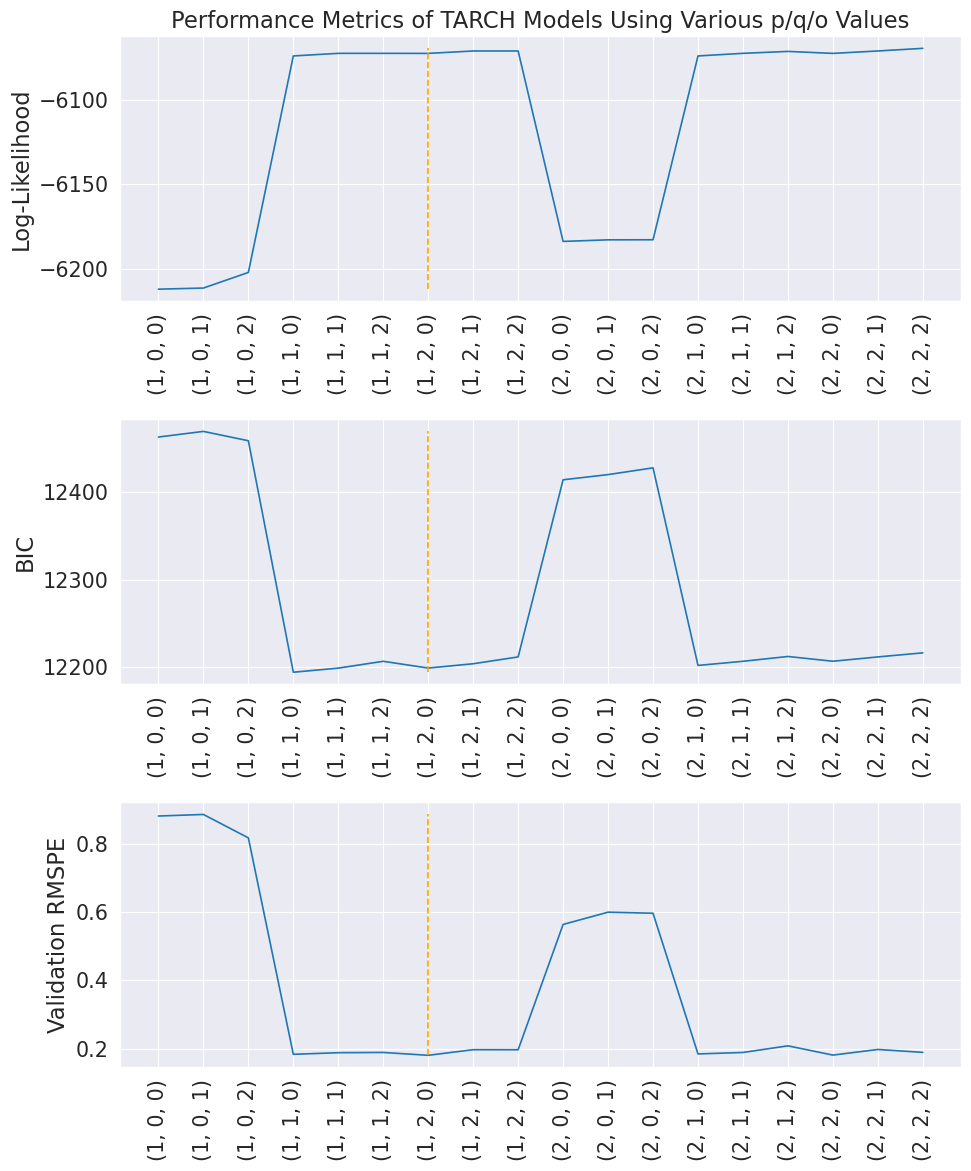

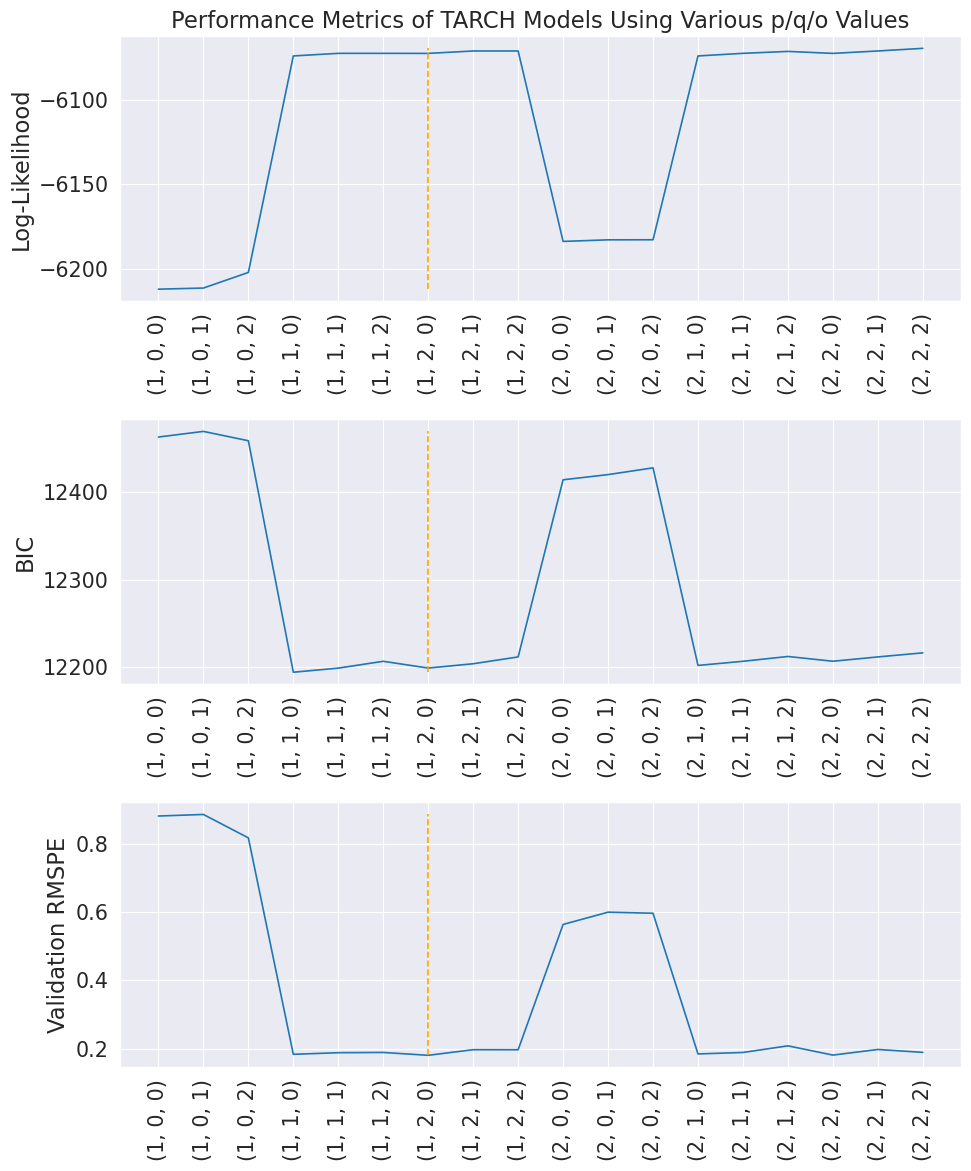

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
with sns.axes_style("darkgrid"):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10,12))
    xlabels = [str(v) for v in pqo_s]

    ax1.plot(xlabels, LLH_s)
    ax1.set_xticklabels(xlabels, rotation=90)
    ax1.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(LLH_s), ymax=np.max(LLH_s))
    ax1.set_ylabel('Log-Likelihood')

    ax2.plot(xlabels, bic_s)
    ax2.set_xticklabels(xlabels, rotation=90)
    ax2.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(bic_s), ymax=np.max(bic_s))
    ax2.set_ylabel('BIC')

    ax3.plot(xlabels, rmspe_s)
    ax3.set_xticklabels(xlabels, rotation=90)
    ax3.vlines(x=str(best_pqo), 
               ls='--', color='orange',
               ymin=np.min(rmspe_s), ymax=np.max(rmspe_s))
    ax3.set_ylabel('Validation RMSPE')

    ax1.set_title('Performance Metrics of TARCH Models Using Various p/q/o Values')
    plt.tight_layout()
    plt.show();    
plt.savefig('plots/plot13_find_best_TARCH')


So it seems (1,2,0) yields lowest RMPSE on validation set among all the variants I've tried. I'm going to create another TARCH model with this paramaters to see how the results would look like.

### 3.4. Final GARCH Model - TARCH(1,2)

I will train another sets of TARCH model using the p/q/o values found from tuning above.

In [ ]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

t_120 = arch_model(r_train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                  dist='skewt')
result_4 = t_120.fit(disp='off')
print(result_4.summary())

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_tarch_120, scaled_tarch_120_cond_vol = scale_tf_cond_vol(result_4)

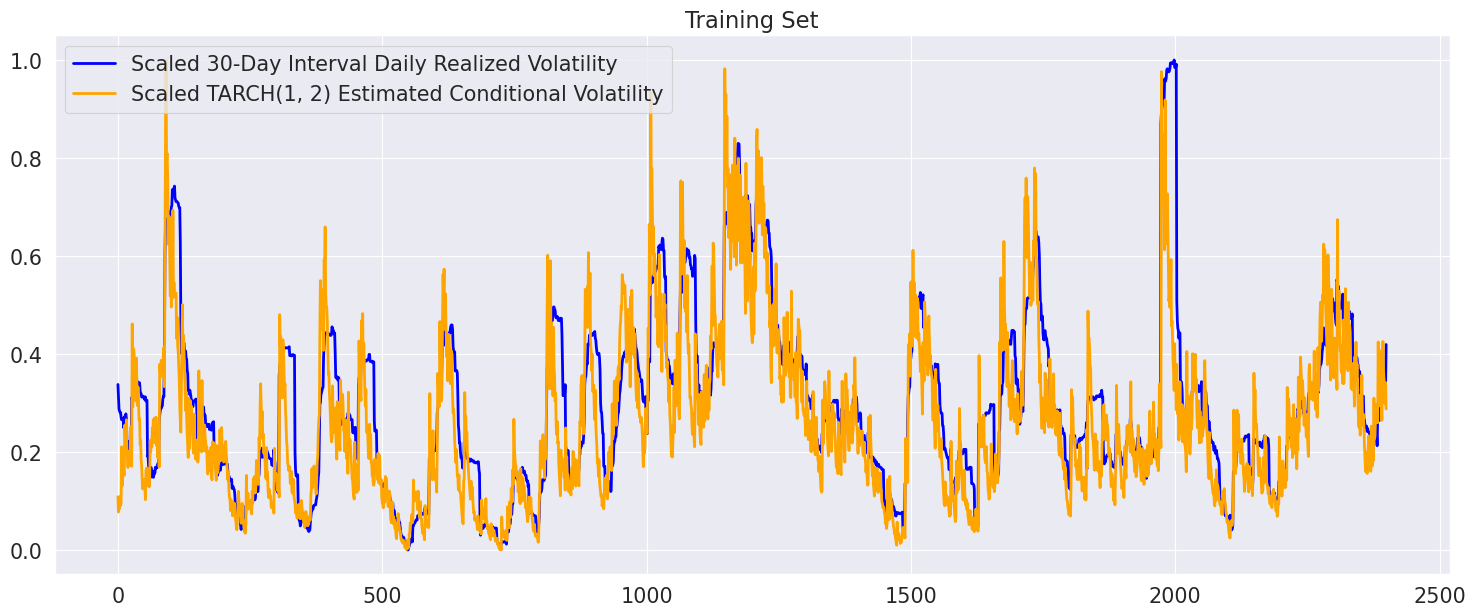

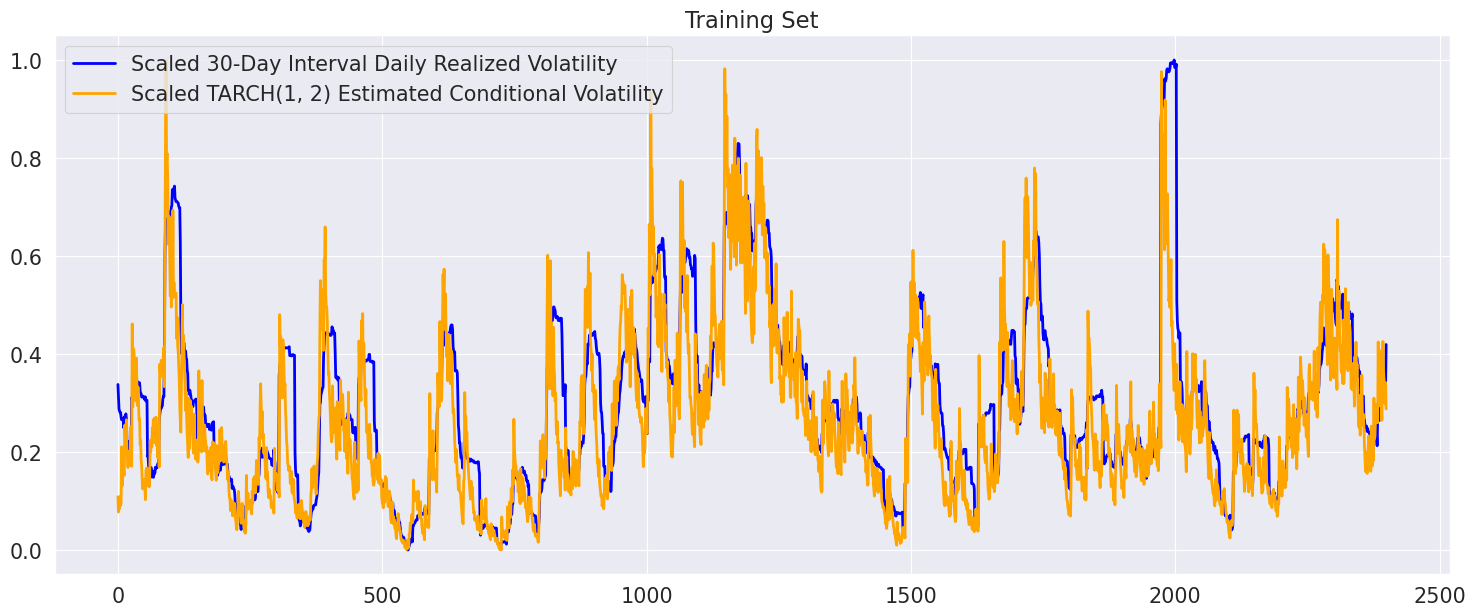

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
viz_cond_vol(scaled_tarch_120_cond_vol, f'TARCH{best_pqo[:2]}')
plt.savefig('plots/plot14_TARCH(1,2)estimate_trainingData')

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='bootstrap').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_120_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/loc

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_120_preds_scaled = transform_volatility_to_scaler(scaler_tarch_120, t_bs_120_preds)

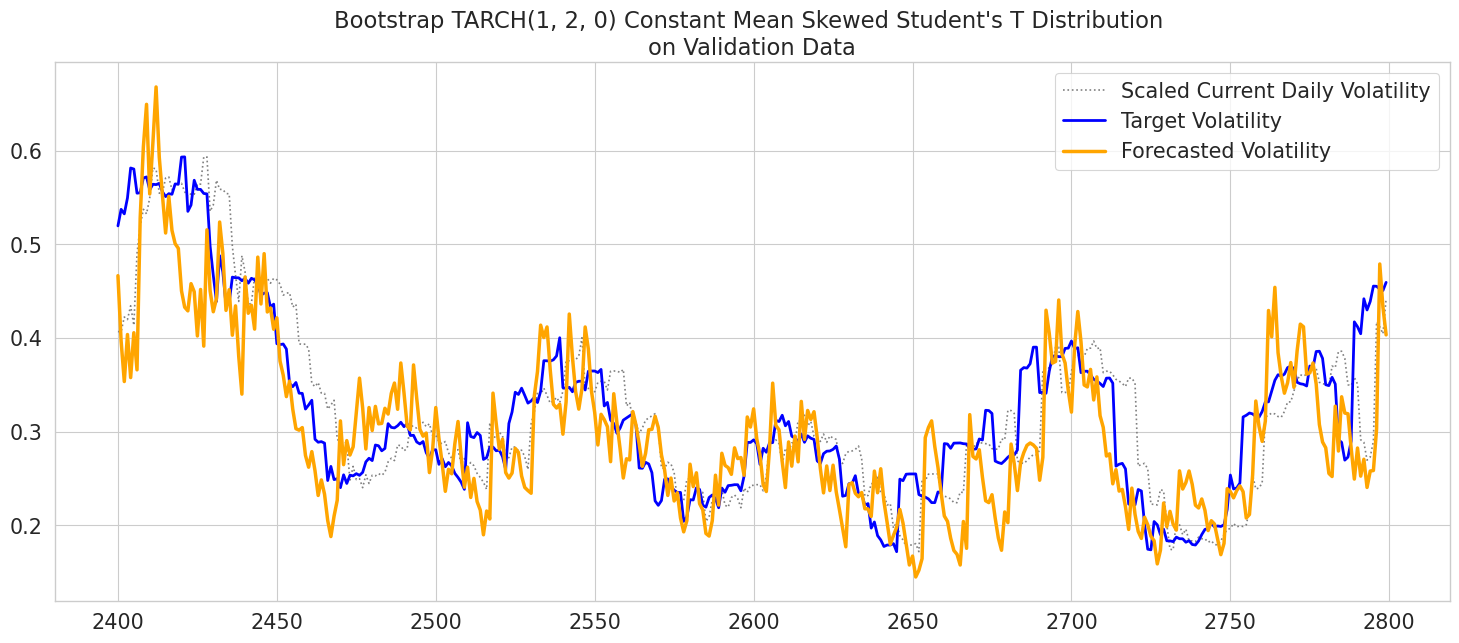

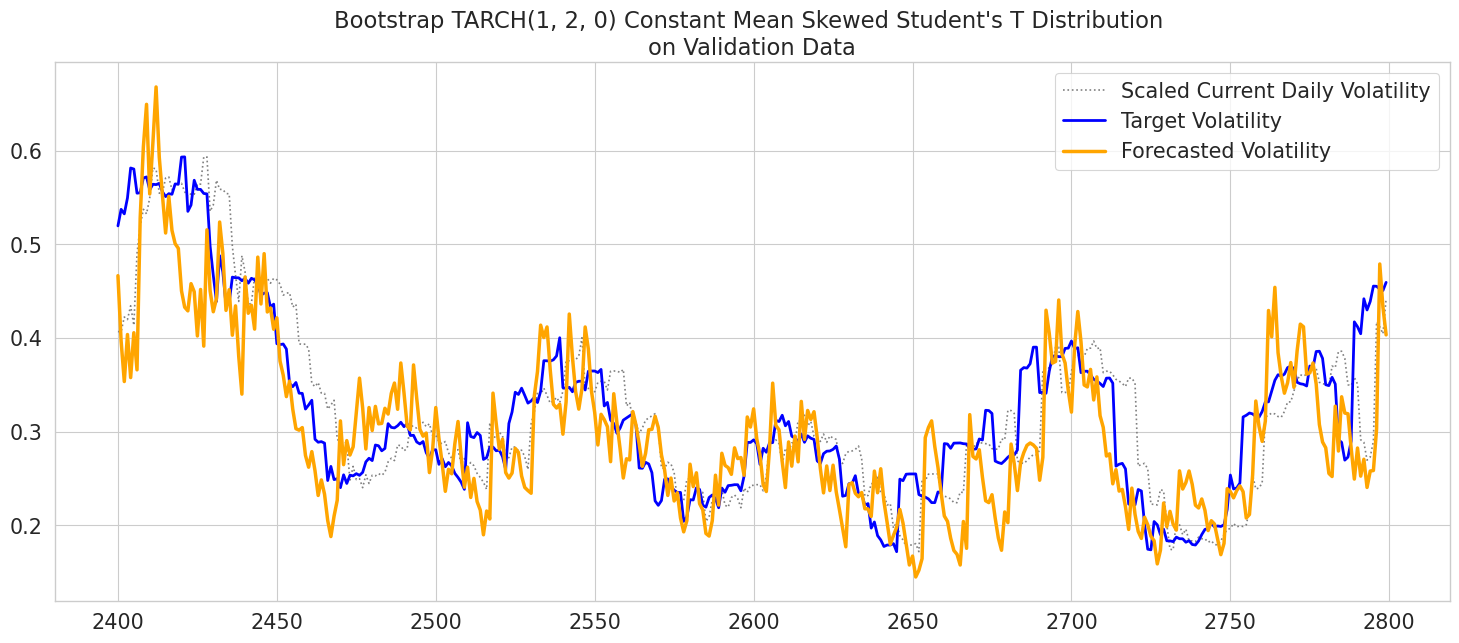

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_120_preds_scaled, 
          f"Bootstrap TARCH{best_pqo} Constant Mean Skewed Student's T Distribution")
plt.savefig('plots/plot15_bootstrap_TARCH(1,2)forecasting_validationData(best_tarch).png')
            
plt.show();

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_120_preds_scaled, 
         f"Bootstrap TARCH{best_pqo}, Constant Mean, Skewt Dist")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.277381,0.099119
1,Random Walk Naive Forecasting,0.159563,0.049610
2,"GARCH(1,1), Constant Mean, Normal Dist",0.563884,0.186670
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Sk...",0.249559,0.084548
4,"Bootstrap TARCH(1,1), Constant Mean, Skewt Dist",0.188235,0.066256
5,"Simulation TARCH(1,1), Constant Mean, Skewt Dist",0.194583,0.069195
6,"Bootstrap TARCH(1, 2, 0), Constant Mean, Skewt...",0.179903,0.060788


In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=best_pqo[0], q=best_pqo[1], o=best_pqo[2], power=1.0,
                       dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    # USING BOOTSTRAP METHOD
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False,
                             method='simulation').variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

t_bs_120_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/arch/univariate/base.py:756: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/loc

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
t_120_preds_scaled = transform_volatility_to_scaler(scaler_tarch_120, t_bs_120_preds)

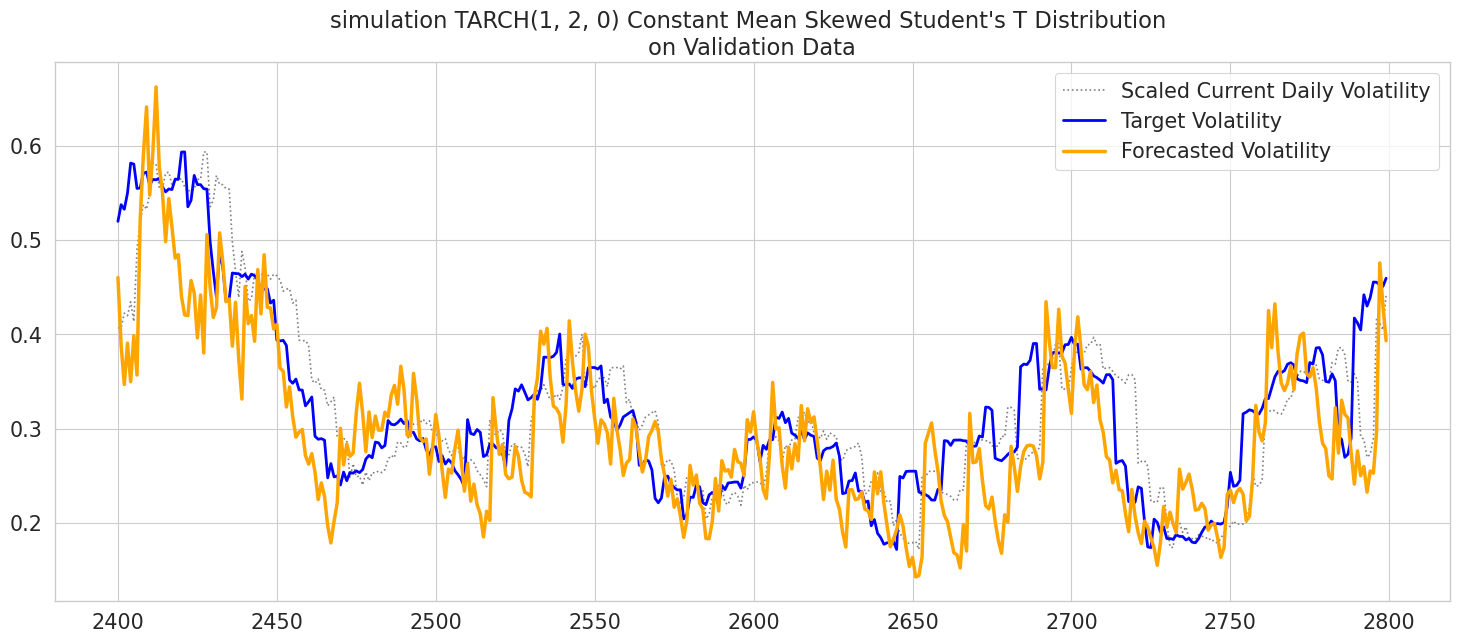

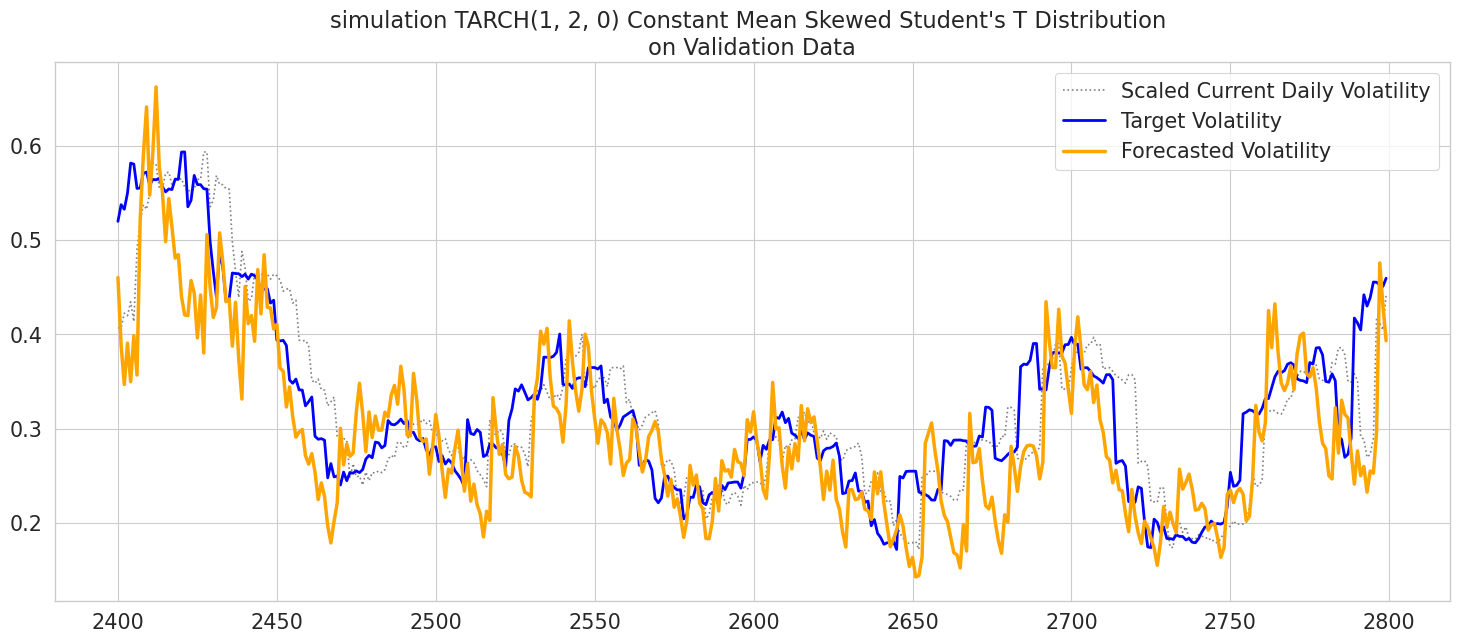

In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, t_120_preds_scaled, 
          f"simulation TARCH{best_pqo} Constant Mean Skewed Student's T Distribution")
plt.savefig('plots/plot16_simulation_TARCH(1,2)forecasting_validationData(best_tarch).png')
            
plt.show();

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, t_120_preds_scaled, 
         f"simulation TARCH{best_pqo}, Constant Mean, Skewt Dist")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.277381,0.099119
1,Random Walk Naive Forecasting,0.159563,0.049610
2,"GARCH(1,1), Constant Mean, Normal Dist",0.563884,0.186670
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Sk...",0.249559,0.084548
4,"Bootstrap TARCH(1,1), Constant Mean, Skewt Dist",0.188235,0.066256
5,"Simulation TARCH(1,1), Constant Mean, Skewt Dist",0.194583,0.069195
6,"Bootstrap TARCH(1, 2, 0), Constant Mean, Skewt...",0.179903,0.060788
7,"simulation TARCH(1, 2, 0), Constant Mean, Skew...",0.182605,0.062852


In [ ]:
perf_df.to_csv('GARCH_MODELS_OUTPUTS.csv')

In [ ]:
files.download('GARCH_MODELS_OUTPUTS.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>